# Model performance analysis
### By: Diego Coello de Portugal Mecke

This notebook aims to asses the performance of the model in a classification setting.
This will be done by:

1) Checking the loss and accuracy for train and test set to detect overfitting.

2) Use the confusion matrix to show which classes are more difficult to predict. This can give you insight on which classes you should focus if you want to increase the dataset.

3) Show the images with the least confidence. This can be used to find outliers in the dataset.

----

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Add, Layer
from tensorflow.keras import Sequential, layers
from tensorflow.keras import Model as Model_
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
from sklearn.metrics import ConfusionMatrixDisplay
import torch

# Data loading

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

label =["airplane",
		"automobile",
		"bird",
		"cat",
		"deer",
		"dog",
		"frog",
		"horse",
		"ship",
		"truck"]

In [3]:
print(f'Dataset:\n  - Train instances: {x_train.shape[0]}\n  - Test instances: {x_test.shape[0]}\n')
print(f'Input:\n  - Shape: {x_train[0].shape}\n  - Range: [{tf.math.reduce_min(x_train)}-{tf.math.reduce_max(x_train)}]\n')
print(f'Output:\n  - Shape: {y_train[0].shape}\n  - Range: [{tf.math.reduce_min(y_train)}-{tf.math.reduce_max(y_train)}]')

Dataset:
  - Train instances: 50000
  - Test instances: 10000

Input:
  - Shape: (32, 32, 3)
  - Range: [0-255]

Output:
  - Shape: (1,)
  - Range: [0-9]


In [4]:
#Normalize data
x_train = x_train/255.0
x_test = x_test/255.0

print(f'Input:\n  - Shape: {x_train[0].shape}\n  - Range: [{tf.math.reduce_min(x_train)}-{tf.math.reduce_max(x_train)}]')

Input:
  - Shape: (32, 32, 3)
  - Range: [0.0-1.0]


In [5]:
#Crop hyperparameters
img_resize = 38
img_crop = 32

def train_aug(x):
    #Horizontal flip
    x = tf.image.random_flip_left_right(x)
    
    #Resize + Crop
    x = tf.image.resize(x, [img_resize, img_resize])
    x = tf.image.random_crop(x, [img_crop, img_crop, 3])
    return x


def test_aug(x):
    
    #Resize + Crop
    x = tf.image.resize(x, [img_resize, img_resize])
    x = tf.image.central_crop(x, img_crop/float(img_resize))
    return x

In [7]:
# Data augmentation
batch_size = 10
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_loader = (
	train_loader
	.shuffle(len(y_train)//batch_size)
	.map(lambda x, y: (train_aug(x), y))
	.batch(batch_size)
	.prefetch(tf.data.AUTOTUNE)
)

test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_loader = (
	test_loader
	.map(lambda x, y: (test_aug(x), y))
	.batch(batch_size)
	.prefetch(tf.data.AUTOTUNE)
)

# Model definition

In [8]:
class ResBlock(Layer):
    def __init__(self, n, kernel_size):
        super(ResBlock, self).__init__()

        def conv_block(n, kernel_size):
            #return [Conv2D(n,kernel_size,activation="relu"), Conv2D(n,kernel_size,activation="relu"), MaxPooling2D((2,2))]
            return Sequential([Conv2D(n,kernel_size,activation="relu", padding='same'),\
                               Conv2D(n,kernel_size,activation="relu", padding='same'),\
                               MaxPooling2D((2,2))])
        self.convBlock = conv_block(n, kernel_size)
        self.skip = Sequential([Conv2D(n,1,activation="relu", padding='same'), MaxPooling2D((2,2))])
        self.out  = Add()

    def call(self, x_input):
        x_conv = self.convBlock(x_input)
        x_skip = self.skip(x_input)
        x_out = self.out([x_conv, x_skip])
        return tf.nn.relu(x_out)

In [9]:
class MyModel(Model_):
    def __init__(self):
        super(MyModel, self).__init__()

        self.res_1 = ResBlock(30,3)  
        self.res_2 = ResBlock(60,3)  
        self.res_3 = ResBlock(90,3)               

        self.flat = Flatten()
        self.dense  = Sequential([Dense(120,activation="relu"),Dense(50,activation="relu")])
        self.out  = Dense(10)

    def call(self, x_input):
        x_res_1 = self.res_1(x_input)
        x_res_2 = self.res_2(x_res_1)
        x_res_3 = self.res_3(x_res_2)

        x = self.flat(x_res_3)
        x = self.dense(x)
        return tf.nn.softmax(self.out(x))

# Training model

In [10]:
mymodel = MyModel()

initial_learning_rate = 0.00015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                        initial_learning_rate,
                        decay_steps=10000,
                        decay_rate=0.96,
                        staircase=True)


mymodel.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics="accuracy")

trainHist = mymodel.fit(train_loader, validation_data=test_loader, epochs=30)

Epoch 1/30
5000/5000 [==============================] - 31s 5ms/step - loss: 1.6787 - accuracy: 0.3794 - val_loss: 1.3611 - val_accuracy: 0.5062
Epoch 2/30
5000/5000 [==============================] - 26s 5ms/step - loss: 1.3393 - accuracy: 0.5166 - val_loss: 1.1874 - val_accuracy: 0.5751
Epoch 3/30
5000/5000 [==============================] - 26s 5ms/step - loss: 1.1437 - accuracy: 0.5917 - val_loss: 1.0815 - val_accuracy: 0.6127
Epoch 4/30
5000/5000 [==============================] - 27s 5ms/step - loss: 1.0176 - accuracy: 0.6401 - val_loss: 0.9177 - val_accuracy: 0.6828
Epoch 5/30
5000/5000 [==============================] - 29s 6ms/step - loss: 0.9196 - accuracy: 0.6770 - val_loss: 0.8229 - val_accuracy: 0.7171
Epoch 6/30
5000/5000 [==============================] - 26s 5ms/step - loss: 0.8481 - accuracy: 0.7021 - val_loss: 0.8100 - val_accuracy: 0.7172
Epoch 7/30
5000/5000 [==============================] - 25s 5ms/step - loss: 0.7968 - accuracy: 0.7193 - val_loss: 0.7490 - val_ac

In [11]:
mymodel.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_block (ResBlock)        multiple                  9090      
                                                                 
 res_block_1 (ResBlock)      multiple                  50580     
                                                                 
 res_block_2 (ResBlock)      multiple                  127170    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 sequential_6 (Sequential)   (None, 50)                178970    
                                                                 
 dense_2 (Dense)             multiple                  510       
                                                                 
Total params: 366,320
Trainable params: 366,320
Non-traina

# Model performance assestment

## Training curves

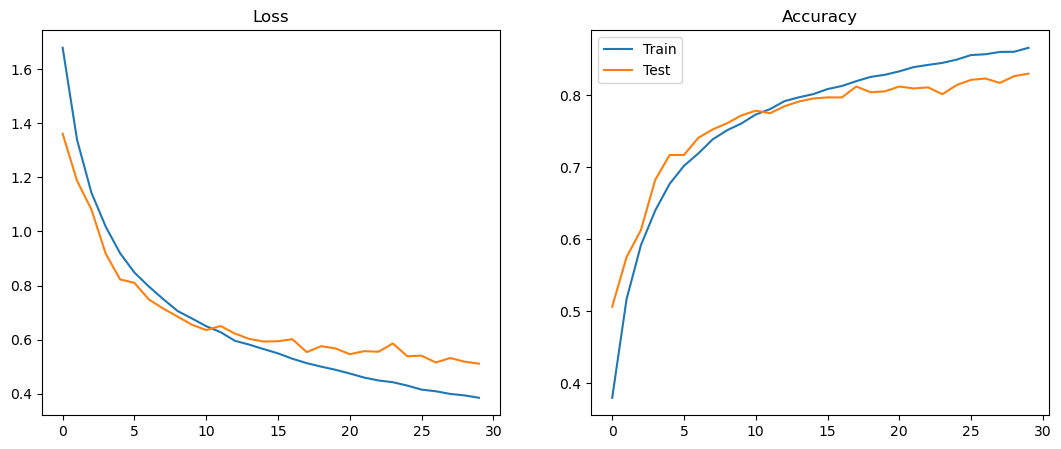

In [12]:
fig = plt.figure(figsize=(13,5))
gs = grid.GridSpec(1,2)

ax = plt.subplot(gs[0,0])
ax.plot(trainHist.history["loss"],label="Train")
ax.plot(trainHist.history["val_loss"],label="Test")
ax.set_title("Loss")

ax = plt.subplot(gs[0,1])
ax.plot(trainHist.history["accuracy"],label="Train")
ax.plot(trainHist.history["val_accuracy"],label="Test")
ax.set_title("Accuracy")

plt.legend()

The training curves in this case show a desirable behaviour. Nevertheless, this courves are very usefull to pinpoint training problems such as overfitting or underfitting.

In this case, we can see that the model could still train for some more iterations to improve its performance since the curves have not yet plateaud.

## Confusion Matrix

In [13]:
y_pred = mymodel.predict(x_test)
y_pred_arg = tf.math.argmax(y_pred, axis=1)
cm = tf.math.confusion_matrix(y_pred_arg, y_test).numpy()

313/313 [==============================] - 1s 2ms/step


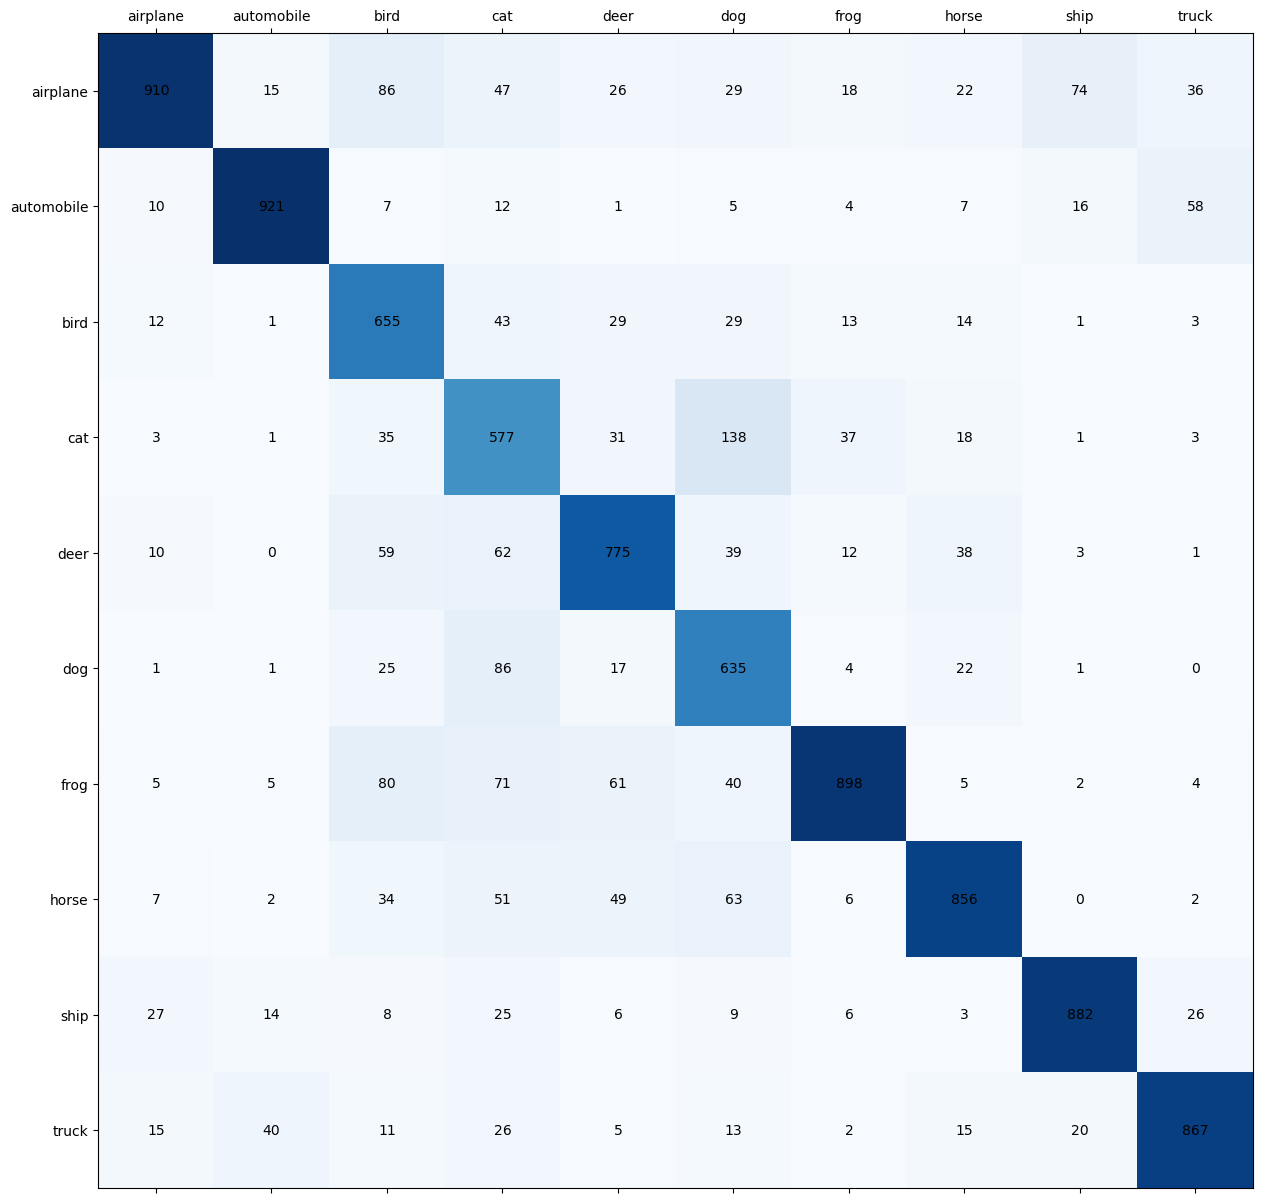

In [14]:
bfig, ax = plt.subplots(figsize=(15,15))
min_val, max_val = 0, len(y_test)
ax.matshow(cm, cmap='Blues')

for i in range(10):
    for j in range(10):
        c = cm[j, i]
        ax.text(i, j, str(c), va='center', ha='center')

plt.xticks(list(range(10)), label)
plt.yticks(list(range(10)), label)
plt.show()

Here you can observe how classes with similar characteristics such as the vehicle group (automovile, airplane, ship and truck) or animals group (cat, dog, deer, ...) have higher confusion between themselfs than when selecting one class of each group. This makes sense since classes such as ship and airplane are more similar than ship and deer.

This can be also used to find dificult classes, which would be speciallz usefull if zou consider a dataset where one class would be assign to other images, i.e., images that do not belong to anz of the previous classes.

# Lowest confident images

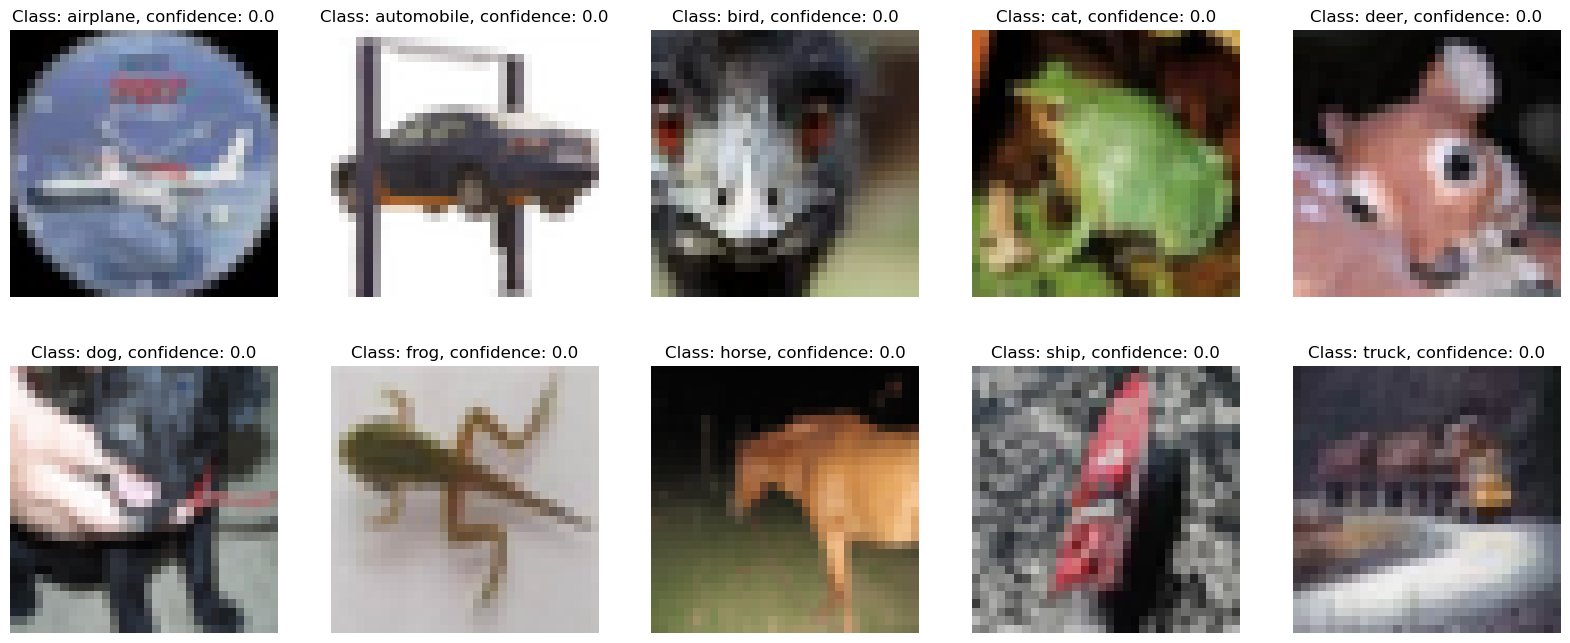

In [15]:
fig = plt.figure(figsize=(20,8))
gs = grid.GridSpec(2,5)

for i in range(2):
    for j in range(5):

        ax = plt.subplot(gs[i,j])
        cl = j+i*5
        labels_class = np.where(y_test==cl)[0]
        idx = labels_class[np.argmin(y_pred[labels_class,cl])]
        img = x_test[idx]
        ax.imshow(img)
        ax.set_title(f"Class: {label[cl]}, confidence: {round(y_pred[idx,cl],1)}")
        ax.axis("off")

Here I show some of the most difficult image of each class for the model.

In particular, there are some images that I would like to emphasize on:

 - The "cat" image is clearly a frog, which should be relabeled or removed in a real world scenario. By showing more images a more in depth data cleaning could be performed.

 - The "airplaine" image is a clock with an airplane on it. Is this something that the model should recognize as an airplaine? Is it part of the image distribution the model should consider?